In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

import os

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

import camb

In [3]:
kSZFiles = os.listdir('./Data/kSZ')

nside = 64
numSets = len(kSZFiles)

In [8]:
#Make Fake CMB
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

/tmp/ipykernel_1362/1080535136.py:11: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


In [26]:
kSZData = np.zeros((numSets,12*nside**2))
observedMaps = np.zeros((numSets,12*nside**2))

In [27]:
for i in range(numSets):
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
    #kSZData[i] = 100*kSZData[i]/np.linalg.norm(kSZData[i])
    observedMaps[i] = kSZData[i] + hp.reorder(hp.sphtfunc.synfast(CMB_camb,nside=nside),r2n=True)

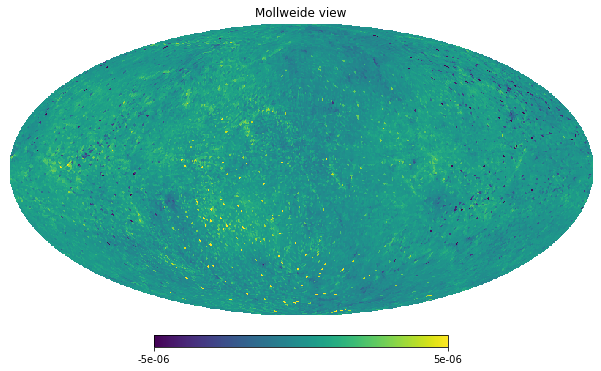

In [28]:
hp.mollview(kSZData[3],nest=True,max=0.5*10**-5,min=-0.5*10**-5)

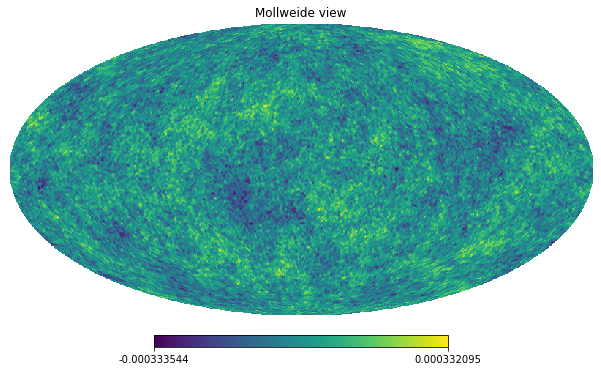

In [29]:
hp.mollview(observedMaps[3],nest=True)

In [30]:
y_train, y_test = np.split(kSZData, indices_or_sections=[numSets-numSets//20])
x_train, x_test = np.split(observedMaps, indices_or_sections=[numSets-numSets//20])

In [34]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.shuffle(20)
dset_test = dset_test.batch(8)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(200)
dset_train = dset_train.batch(8)

2023-05-30 19:10:17.269805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 19:10:17.326551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 19:10:17.327322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 19:10:17.328852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

dset_train = dset_train.prefetch(buffer_size=AUTOTUNE)
dset_test = dset_test.prefetch(buffer_size=AUTOTUNE)

In [36]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [45]:
K = 5
layersBest = [#hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=64, activation="linear"),
                  tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=64, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="sigmoid"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="sigmoid"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
#                   hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
#                                    activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPool(p=1,pool_type='MAX'),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=24, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear")
         ]

In [46]:
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
modelHP = HealpyGCNN(nside=nside, layers=layersBest,indices=np.arange(0,12*nside**2), n_neighbors=40)
modelHP.build(input_shape=(None, len(indices), 1))
modelHP.summary(110)

Detected a reduction factor of 1.0, the input with nside 64 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_4"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 batch_normalization_1 (BatchNormalization)      (None, 49152, 1)                            4                
                                                                                                              
 chebyshev_14 (Chebyshev)                        (None, 49152, 64)                           384              
                                                                                                              
 chebyshev_15 (Chebyshev)                        (None, 49152, 32)                           10272            
                       

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

modelHP.compile(optimizer=opt,
              #loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                loss="CosineSimilarity",
              metrics=[r_square]
)

checkpoint_filepath = './checkpoint'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath+"/{epoch}",
#     save_weights_only=False,
#     monitor='loss',
#     save_freq=3
# )
filePath = "./models2/Model1_weights.{epoch:02d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filePath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min')

In [48]:
initial_epochs = 20
history = modelHP.fit(
    dset_train,
    epochs=initial_epochs,
    validation_data = dset_test,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
177/177 [==============================] - 202s 1s/step - loss: 0.0063 - r_square: -2567857330192384.0000 - val_loss: -0.0037 - val_r_square: -1272654778597376.0000
Epoch 2/20
177/177 [==============================] - 202s 1s/step - loss: -0.0112 - r_square: -16433189119590400.0000 - val_loss: 0.0093 - val_r_square: -38307942889422848.0000
Epoch 3/20
177/177 [==============================] - 201s 1s/step - loss: -0.0202 - r_square: -37560197673123840.0000 - val_loss: 0.0097 - val_r_square: -28066713631195136.0000
Epoch 4/20
177/177 [==============================] - 201s 1s/step - loss: -0.0206 - r_square: -30411602566053888.0000 - val_loss: 0.0082 - val_r_square: -28094583673978880.0000
Epoch 5/20
177/177 [==============================] - 200s 1s/step - loss: -0.0210 - r_square: -33796260133601280.0000 - val_loss: 0.0064 - val_r_square: -65253549797277696.0000
Epoch 6/20
177/177 [==============================] - 201s 1s/step - loss: -0.0215 - r_square: -6057836193146470

KeyboardInterrupt: 

In [44]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_further = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dset_test)

Epoch 20/60
177/177 [==============================] - 199s 1s/step - loss: -0.3228 - r_square: -34682804633600.0000 - val_loss: 0.0076 - val_r_square: -30508807356416.0000
Epoch 21/60
177/177 [==============================] - 199s 1s/step - loss: -0.3396 - r_square: -25071716401152.0000 - val_loss: 0.0067 - val_r_square: -23069533929472.0000
Epoch 22/60
177/177 [==============================] - 199s 1s/step - loss: -0.3533 - r_square: -20009669623808.0000 - val_loss: 0.0071 - val_r_square: -20197230510080.0000
Epoch 23/60
177/177 [==============================] - 199s 1s/step - loss: -0.3638 - r_square: -15444110999552.0000 - val_loss: 0.0069 - val_r_square: -18775764107264.0000
Epoch 24/60
141/177 [======================>.......] - ETA: 39s - loss: -0.3675 - r_square: -14814972739584.0000

KeyboardInterrupt: 